# STORM

[STORM](https://arxiv.org/abs/2402.14207) is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.

STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density. 

The control flow looks like the diagram below.

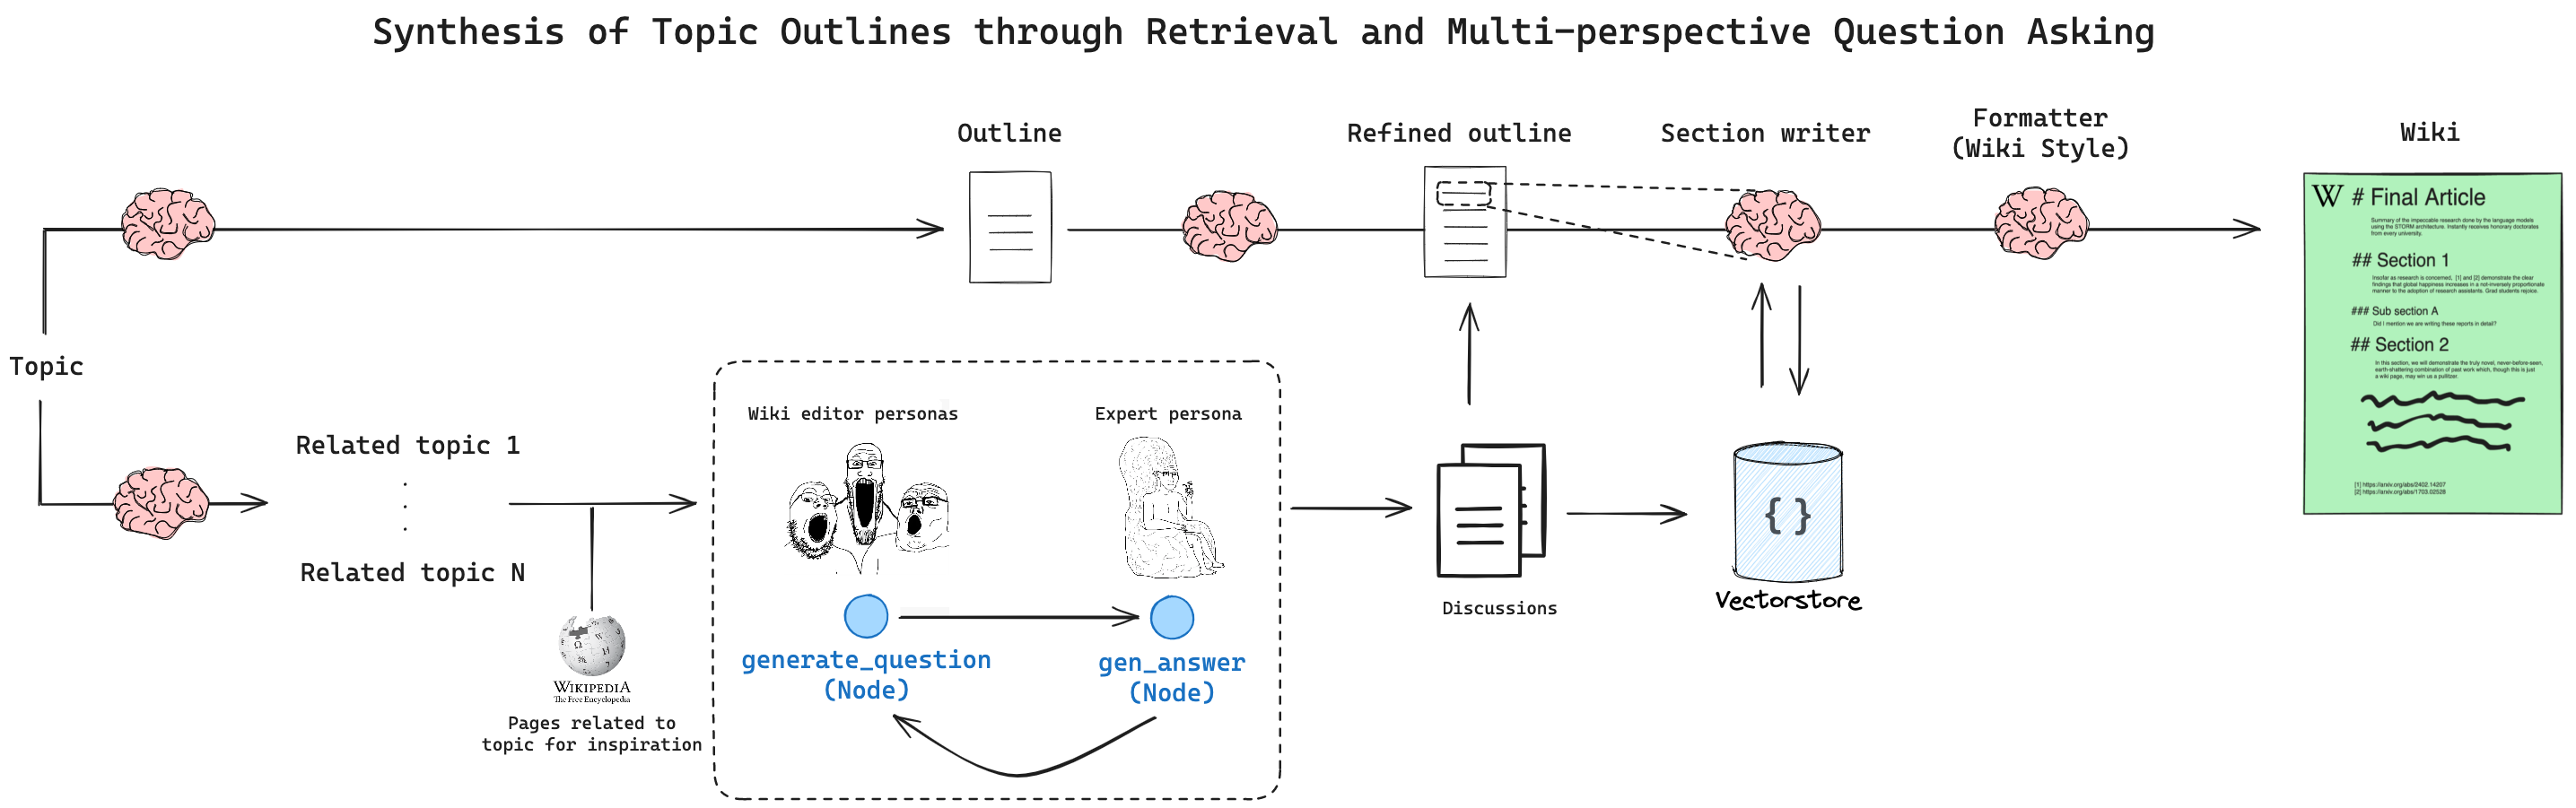

STORM has a few main stages:

1. Generate initial outline + Survey related subjects
2. Identify distinct perspectives
3. "Interview Subject_Matter_Experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article


The expert interviews stage ocurrs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

There are a couple hyperparameters you can set to restrict the (potentially) infinite research breadth:

N: Number of perspectives to survey / use (Steps 2->3)
M: Max number of conversation turns in step (Step 3)


## Prerequisites

In [1]:
# %pip install -U langchain_community langchain_openai langgraph wikipedia  scikit-learn  langchain_fireworks
# We use one or the other search engine below
# %pip install -U duckduckgo tavily-python

In [2]:
# Uncomment if you want to draw the pretty graph diagrams.
# If you are on MacOS, you will need to run brew install graphviz before installing and update some environment flags
# ! brew install graphviz
# !CFLAGS="-I $(brew --prefix graphviz)/include" LDFLAGS="-L $(brew --prefix graphviz)/lib" pip install -U pygraphviz


In [3]:
import os
import getpass

from dotenv import load_dotenv
load_dotenv()

print('='*30)
os.environ["OPENAI_API_KEY"] = "sk-rODprG14bz0DDDji0789118b88A845E8815929D260627eB5"

import dashscope
dashscope.api_key="sk-ef681782a96a4e209361983e377df643"
os.environ["DASHSCOPE_API_KEY"] = "sk-ef681782a96a4e209361983e377df643"

for key, value in os.environ.items():
    if 'OPENAI' in key: # openai
        print(f'{key}: {value}')
    if 'DASH' in key: # tongyi
        print(f'{key}: {value}')

OPENAI_API_KEY: sk-rODprG14bz0DDDji0789118b88A845E8815929D260627eB5
DASHSCOPE_API_KEY: sk-ef681782a96a4e209361983e377df643


In [4]:
from langchain_openai import ChatOpenAI
from langchain_fireworks import ChatFireworks

# fast_llm = ChatOpenAI(model="gpt-4")
# fast_llm = ChatOpenAI(model="gpt-4")
# fast_llm = ChatOpenAI(model="gpt-3.5-turbo")
# fast_llm = ChatOpenAI(model='gpt-3.5-turbo')
# fast_llm = CustomChatOpenAI(model='gpt-4o')
openai = ChatOpenAI(model='gpt-4') 

In [5]:
from typing import Any, Dict, Type
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import Runnable
from langchain_core.output_parsers.openai_tools import (
    JsonOutputKeyToolsParser,
    PydanticToolsParser,
)
from langchain_core.output_parsers.base import OutputParserLike
from langchain_core.utils.function_calling import convert_to_openai_tool
from typing import (
    Any,
    Callable,
    Sequence,
    Type,
    Union,
    TypeVar,
    Optional,
)
from langchain_core.language_models import LanguageModelInput
from langchain_core.runnables import Runnable, RunnableMap, RunnablePassthrough
from operator import itemgetter
from langchain_core.messages import (
    BaseMessage,
)
from langchain_core.tools import BaseTool
from typing_extensions import Literal, get_args
from langchain_core.output_parsers import (
    JsonOutputParser,
    PydanticOutputParser,
)
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_core.messages import HumanMessage



_BM = TypeVar("_BM", bound=BaseModel)
_DictOrPydanticClass = Union[Dict[str, Any], Type[_BM]]
_DictOrPydantic = Union[Dict, _BM]


def _is_pydantic_class(obj: Any) -> bool:
    return isinstance(obj, type) and issubclass(obj, BaseModel)


class MyChatTongyi(ChatTongyi):
   
    class Config:
        """Configuration for this pydantic object."""
        allow_population_by_field_name = True
        arbitrary_types_allowed = True
    
    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[dict, str, Literal["auto", "none"], bool]] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        """Bind tool-like objects to this chat model.

        Assumes model is compatible with OpenAI tool-calling API.

        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be  a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require the model to call.
                Must be the name of the single provided function or
                "auto" to automatically determine which function to call
                (if any), or a dict of the form:
                {"type": "function", "function": {"name": <<tool_name>>}}.
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """

        formatted_tools = [convert_to_openai_tool(tool) for tool in tools]
        if tool_choice is not None and tool_choice:
            if len(formatted_tools) != 1:
                raise ValueError(
                    "When specifying `tool_choice`, you must provide exactly one "
                    f"tool. Received {len(formatted_tools)} tools."
                )
            if isinstance(tool_choice, str):
                if tool_choice not in ("auto", "none"):
                    tool_choice = {
                        "type": "function",
                        "function": {"name": tool_choice},
                    }
            elif isinstance(tool_choice, bool):
                tool_choice = {
                    "type": "function",
                    "function": {"name": formatted_tools[0]["function"]["name"]},
                }
            elif isinstance(tool_choice, dict):
                if (
                    formatted_tools[0]["function"]["name"]
                    != tool_choice["function"]["name"]
                ):
                    raise ValueError(
                        f"Tool choice {tool_choice} was specified, but the only "
                        f"provided tool was {formatted_tools[0]['function']['name']}."
                    )
            else:
                raise ValueError(
                    f"Unrecognized tool_choice type. Expected str, bool or dict. "
                    f"Received: {tool_choice}"
                )
            kwargs["tool_choice"] = tool_choice
        return super().bind(tools=formatted_tools, **kwargs)
    
    def with_structured_output(
        self,
        schema: Optional[_DictOrPydanticClass] = None,
        *,
        method: Literal["function_calling", "json_mode"] = "function_calling",
        include_raw: bool = False,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, _DictOrPydantic]:
        if kwargs:
            raise ValueError(f"Received unsupported arguments {kwargs}")
        is_pydantic_schema = _is_pydantic_class(schema)
        if method == "function_calling":
            if schema is None:
                raise ValueError(
                    "schema must be specified when method is 'function_calling'. "
                    "Received None."
                )
            llm = self.bind_tools([schema], tool_choice=True)
            if is_pydantic_schema:
                output_parser: OutputParserLike = PydanticToolsParser(
                    tools=[schema], first_tool_only=True
                )
            else:
                key_name = convert_to_openai_tool(schema)["function"]["name"]
                output_parser = JsonOutputKeyToolsParser(
                    key_name=key_name, first_tool_only=True
                )
        elif method == "json_mode":
            llm = self.bind(response_format={"type": "json_object"})
            output_parser = (
                PydanticOutputParser(pydantic_object=schema)
                if is_pydantic_schema
                else JsonOutputParser()
            )
        else:
            raise ValueError(
                f"Unrecognized method argument. Expected one of 'function_calling' or "
                f"'json_format'. Received: '{method}'"
            )

        if include_raw:
            parser_assign = RunnablePassthrough.assign(
                parsed=itemgetter("raw") | output_parser, parsing_error=lambda _: None
            )
            parser_none = RunnablePassthrough.assign(parsed=lambda _: None)
            parser_with_fallback = parser_assign.with_fallbacks(
                [parser_none], exception_key="parsing_error"
            )
            return RunnableMap(raw=llm) | parser_with_fallback
        else:
            return llm | output_parser

#### Select LLMs

We will have a faster LLM do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [6]:
! pip install dashscope

In [7]:
from langchain_openai import ChatOpenAI
from langchain_fireworks import ChatFireworks

fast_llm = MyChatTongyi(model='qwen-plus')
long_context_llm = MyChatTongyi(model="qwen-plus")

## Generate Initial Outline

For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial
outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

你是一名文章题材的撰稿人。 现在需要为用户提供产业月度报告， 请注意:
产业月度报告是一种定期编写的报告，用于总结和分析特定产业在一个月内的活动、变化、趋势和未来展望。它可以帮助公司管理层、投资者和其他利益相关者了解产业的最新动态，以便做出更好的决策。以下是产业月度报告的标准书写格式

请根据用户提供的话题，注意以下问题，给用户生成大纲: 
1、现报告内图表数据时间跨度长，聚焦全国及各省份。建议数据数据关注月报当前年度下各月各央企的开发、建设、发电小时数等情况。这些数据中电联有，但是各家上报给中电联的数据不一定真实，建议采用由各家企业上报国资委数据。
2、建议新能源分类参考焕新方案 “风光储氢核”的分类方法。
3、第二部分政策动态不需要关注地方动态，关注当月国家发布的政策文件中与新能源相关的部分。
4、第三部分可以大标题设为X月新能源央企动态，重点关注当月新能源央企的重大项目、技术突破、新成立的专精特新组织或企业、新推出的设备或装备。
5、第四部分关注其他新能源企业的动态，分别关注国内新能源民营企业（关注点与央企相似）及国外新能源企业（在央企基础上加一个国外的政策发布情况）

In [8]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate

# original topic: 
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你是一名文章题材的撰稿人。为用户提供的主题编写一个类似维基百科页面的大纲。请明确主题并且系统全面的进行撰写。""",
        ),
        ("user", "{topic}"),
    ]
)

class Subsection(BaseModel):
    subsection_title: str = Field(..., title="小节标题")
    description: str = Field(..., title="小节内容")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="章节标题")
    description: str = Field(..., title="章节内容")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="页面各小节的标题和内容。",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="页面标题")
    sections: List[Section] = Field(
        default_factory=list,
        title="页面各章节的标题和内容。",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)


In [9]:
from tenacity import retry, stop_after_attempt, wait_exponential
import traceback

def print_retrying(retry_state):
    print("Retrying... (Attempt {})".format(retry_state.attempt_number))
    if retry_state.outcome.failed:
        traceback.print_exception(type(retry_state.outcome.exception()), 
                                  retry_state.outcome.exception(),
                                  retry_state.outcome.exception().__traceback__)

@retry(stop=stop_after_attempt(5), 
       wait=wait_exponential(multiplier=1, min=2, max=5), 
       before_sleep=print_retrying)
async def retryable_generate_outline(state):
    topic = state['topic']
    res = await generate_outline_direct.ainvoke({"topic": topic})
    return res

In [10]:
# example_topic = "Impact of million-plus token context window language models on RAG"
# example_topic = "中央企业在新能源产业的布局"
example_topic = "中央企业在人工智能产业的布局"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})
print(initial_outline.as_str)

# 中央企业在人工智能产业的布局

## 概述

简述中央企业在中国人工智能产业中的角色和重要性，以及其布局的基本情况

## 主要参与企业

列出一些在人工智能领域有显著布局的中央企业，如中国电子科技集团、中国移动等

### 中国电子科技集团

介绍该集团在人工智能领域的研究、产品和服务

### 中国移动

探讨中国移动如何利用AI提升通信服务和技术创新

### 其他重要企业

提及其他中央企业在AI产业的贡献和发展

## 关键项目与成果

列举中央企业主导的一些重要AI项目和取得的标志性成果

## 政策支持与战略规划

分析国家对中央企业在AI产业发展的政策导向和长远规划

## 国际合作与竞争

讨论中央企业在国际人工智能市场上的合作与竞争态势

## 挑战与未来趋势

分析中央企业在AI产业发展中面临的主要挑战以及可能的发展趋势

## 影响与社会价值

阐述中央企业的人工智能布局对中国经济和社会的影响


## Expand Related Topics 

While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [11]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """我正在为下面提到的主题编写一个类似维基百科页面或者报告。请识别并推荐一些关于密切相关主题的维基百科页面。我正在寻找能够提供与
    该主题常见关联的有趣方面的见解的示例，或帮助我了解类似主题的维基百科页面中包含的典型内容和结构的示例。请列出尽可能多的主题和网址。
    感兴趣的主题：{topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="作为背景研究的相关主题的全面列表。",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [12]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['中央企业', '人工智能产业', '布局策略', '科技发展', '中国经济', '智能化转型'])

## Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as "Subject_Matter_Experts" with distinct
backgrounds and affiliations. These will help distribute the search process to encourage a more well-rounded final report.

In [13]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="编辑的主要所属机构。",
    )
    name: str = Field(
        description="编辑的姓名。",
    )
    role: str = Field(
        description="编辑在该主题背景下的角色。",
    )
    description: str = Field(
        description="编辑的关注点、关切和动机的描述。",
    )

    @property
    def persona(self) -> str:
        return f"姓名: {self.name}\n角色: {self.role}\n所属机构: {self.affiliation}\n描述: {self.description}\n"

    # Need a setter to change the relevant information of the editor.

class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="包含编辑及其角色和所属机构的全面列表。",
        # 添加一个 pydantic 验证/限制，使编辑人数最多为 M
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你需要选择一个多元化（且不同）的维基百科编辑组，他们将共同合作创建一个关于该主题的全面文章。每个编辑都代表与该主题相关的不同观点、角色或所属机构。
               你可以使用其他相关主题的维基百科页面作为灵感。对于每个编辑，添加他们将关注的内容的描述。最多生成6位编辑。相关主题的维基页面大纲供参考：
            {examples}
            
            NOTE: 请使用中文回答。
            """,
        ),
        ("user", "感兴趣的主题：{topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | fast_llm.with_structured_output(Perspectives)

In [14]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda, chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)

def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]

def format_docs(docs):
    res = "\n\n".join(format_doc(doc) for doc in docs)
    # print('【WIKI docs】:')
    # print(res)
    return res


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

Possible issues: Can not connect to Wiki due to the proxy.

In [17]:
# example_topic = "Top 100 universites in the US"
example_topic = "美国前100的大学"
perspectives = await survey_subjects.ainvoke(example_topic)


ValueError: status_code: 400 
 code: DataInspectionFailed 
 message: Input data may contain inappropriate content.

In [ ]:
example_topic = "中央企业在人工智能产业的布局"

In [ ]:
perspectives.dict()

## Expert Dialog

Now the true fun begins, each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generate content to generate a refined outline as well as an updated index of reference documents.


### Interview State

The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [ ]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated, Sequence


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

#### Dialog Roles

The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain`), who uses a search engine to answer the questions as accurately as possible.

In [ ]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

# COSTAR 

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """您是一名经验丰富的维基百科编辑，正在编辑一个特定的页面。除了维基百科编辑的身份，您在研究该主题时还有特定的关注点。现在，您正在与一位专家聊天以获取信息。请提出一些好的问题，以获取更多有用的信息。
当您没有更多问题要问时，请说“非常感谢您的帮助！”来结束对话。
请每次只问一个问题，并且不要重复问之前问过的问题。您的问题应与您要编写的主题相关。
要全面且充满好奇心，从专家那里获得尽可能多的独特见解。

保持您特定的视角：

{persona}""".replace('维基', '百度'),
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message

def swap_roles(state: InterviewState, name: str):
    converted = []
    # print('【Before swapped】')
    # print('\n'.join([str(i.__dict__) for i in state['messages']]))
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    # print('【After swapped】')
    # print('\n'.join([str(i.__dict__) for i in converted]))
    # print('-'*50)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]} 

In [ ]:
# messages = [
#     HumanMessage(f"所以你说你正在写关于{example_topic}的文章？")
# ]
# question = await generate_question.ainvoke(
#     {
#         "editor": perspectives.editors[0],
#         "messages": messages,
#     }
# )

# question["messages"][0].content


NameError: name 'perspectives' is not defined

#### Answer questions

The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [ ]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="搜索引擎查询的全面列表，用于回答用户的问题。",
    )

gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "您是一位乐于助人的研究助理。查询搜索引擎以回答用户的问题。",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | fast_llm.with_structured_output(Queries, include_raw=True)


In [ ]:
# query重写
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

NameError: name 'question' is not defined

In [ ]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="用中文回答用户问题的全面答案并附上引用。",
    )
    cited_urls: List[str] = Field(
        description="答案中引用的URL列表。",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\n引用:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你是一名能够有效利用信息的专家。你正在与一位维基百科编辑交流，他希望撰写一个你熟悉主题的维基百科页面。你已经收集了相关信息，现在将使用这些信息形成回答。

使你的回答尽可能详尽，并确保每句话都有收集到的信息支持。
每个回答必须有一个来自可靠来源的引用，格式为脚注，并在回答后重现URL。""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [ ]:
%pip install -U duckduckgo-search

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB 660.6 kB/s eta 0:00:04
   - -------------------------------------- 0.1/2.6 MB 1.1 MB/s eta 0:00:03
   -- ------------------------------------- 0.2/2.6 MB 1.2 MB/s eta 0:00:03
   ---- ----------------------------------- 0.3/2.6 MB 1.4 MB/s eta 0:00:02
   ----- ---------------------------------- 0.4/2.6 MB 1.5 MB/s eta 0:00:02
   -------- ------------------------------- 0.6/2.6 MB 2.0 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.6 MB 2.5 MB/s eta 0:00:01
   ------------------ --------------------- 1.2/2.6 MB 3.2 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.6 MB 3.8 MB/s eta 0:00:01
   --------------------------------- ------ 2.2/2.6 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------  2.6/2.6 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 4.8 MB/s eta 0:00:00
Note: you may nee

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

'''
# Tavily is typically a better search engine, but your free queries are limited
search_engine = TavilySearchResults(max_results=4)

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = tavily_search.invoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]
'''

# DDG 
search_engine = DuckDuckGoSearchAPIWrapper()

@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    print('[Searching query]: %s' % query)
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query, max_results=5)
    return [{"content": r["body"], "url": r["href"]} for r in results]


In [ ]:
from langchain_core.runnables import RunnableConfig
import json
from tenacity import retry, stop_after_attempt, wait_exponential, RetryError
import traceback

def print_retrying(retry_state):
    print("Retrying... (Attempt {})".format(retry_state.attempt_number))
    if retry_state.outcome.failed:
        traceback.print_exception(type(retry_state.outcome.exception()), 
                                  retry_state.outcome.exception(),
                                  retry_state.outcome.exception().__traceback__)

@retry(stop=stop_after_attempt(5), 
       wait=wait_exponential(multiplier=1, min=2, max=5), 
       before_sleep=print_retrying)
async def retryable_gen_answer_chain(swapped_state, name=None, all_query_results=None):
    generated =  await gen_answer_chain.ainvoke(swapped_state)
    # generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return formatted_message, cited_references
 
 
@retry(stop=stop_after_attempt(5), 
       wait=wait_exponential(multiplier=1, min=2, max=5), 
       before_sleep=print_retrying)
async def retryable_gen_queries_chain(swapped_state):
    queries = await gen_queries_chain.ainvoke(swapped_state)
    if queries["parsed"] is None:
        raise Exception('Query generated is None, Retrying')
    return queries 
 
 
async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 7000,
):
    # Check if there is a serialized state in Redis
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await retryable_gen_queries_chain(swapped_state)
    print('【2】Generated query expansions %s' % queries["parsed"].queries)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # print("【2】Generated query results", all_query_results)
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    # print('【3】 dumped result %s, \n -- \n length %s' % (dumped, len(dumped)))
    
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].additional_kwargs["tool_calls"][0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    
    # print("【4】Got tool_call %s" % queries["raw"].additional_kwargs["tool_calls"])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    print('【3】Swapped state: %s' % swapped_state)
    try:
        formatted_message, cited_references = await retryable_gen_answer_chain(swapped_state, 
                                                 name=name, 
                                                 all_query_results=all_query_results) 
    except RetryError: 
        print('【-】 Warning: Retring failed.')
        formatted_message, cited_references = '', {}
    # Clear the Redis state after successful completion
    # redis_client.delete(redis_key)
    return {"messages": [formatted_message], "references": cited_references}




In [ ]:
# example_answer = await gen_answer(
#     {"messages": [HumanMessage(content=question["messages"][0].content)]}
# )
# example_answer["messages"][-1].content

In [ ]:
# example_answer

In [ ]:
1. Question -> 2. query 改写 -> 检索(向量数据库) -> llm -> xx[1], xxx[2]...

In [ ]:
def wrap_text(text, chars_per_line=50):
    # Create a list to hold the wrapped lines
    wrapped_lines = []
    
    # Iterate through the text in chunks of chars_per_line
    for i in range(0, len(text), chars_per_line):
        # Slice the text to get each line and add it to wrapped_lines
        wrapped_lines.append(text[i:i + chars_per_line])
    
    # Join the wrapped lines with newline characters
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

In [ ]:
# example_answer

#### Construct the Interview Graph


Now that we've defined the editor and domain expert, we can compose them in a graph.

In [ ]:
# names = [
#     "James",
#     "Olivia",
#     "William",
#     "Emma",
#     "Benjamin",
#     "Sophia",
#     "Lucas",
#     "Mia",
#     "Henry",
# ]

# for e in perspectives.editors:
#     e.name = names.pop()

In [ ]:
max_num_turns = 5


def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END 
    ### newly added
    if last_question.content.endswith("非常感谢您的帮助!"):
        return END
    
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question)
builder.add_node("answer_question", gen_answer)
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.set_entry_point("ask_question")
interview_graph = builder.compile().with_config(run_name="Conduct Interviews")

<img src="agent.png" alt="Agent Image" width="300" height="400">

In [ ]:
# Interviews #

In [ ]:
# all_interviews = []
# async def run_interviews_for_all_editors(editors, example_topic):
#     for i, editor in enumerate(editors):
#         print('【Editor】: %s -- %s' % (i, editor.name))
#         initial_state = {
#             "editor": editor,
#             "messages": [
#                 # HumanMessage(content=question["messages"][0].content),
#                 AIMessage(
#                     content=f"所以你说你正在写关于{example_topic}的文章？",
#                     name="Subject_Matter_Expert",
#                 )
#             ],
#         }
        
#         states = {'messages': [], 'references': {}, 'editor': editor}
#         final_step = None
#         async for step in interview_graph.astream(initial_state):
#             name = next(iter(step))
#             print(name) ### node name
#             print('--', str(step[name]['messages'])[:300])
#             states['messages'].extend(step[name]["messages"])
#             if name == 'answer_question': #TODO
#                 states['references'].update(step[name]['references'])
#             if END in step:
#                 final_step = step
#                 break
        
#         all_interviews.append(states)
        
#     return all_interviews


# editors = perspectives.editors  # Assuming this is defined somewhere

In [ ]:
# all_interview_results = await run_interviews_for_all_editors(editors, example_topic)

In [ ]:
# from langchain.load import dumps, loads

In [ ]:
# import json
# from pydantic import BaseModel, Field
# from typing import List, Dict, Any, Union
# from langchain.load import dumps, loads
# from langchain_core.messages import BaseMessage

# ## Serialization
# def serialize_data(data: List[Dict[str, Any]]) -> str:
#     def serialize_item(item):
#         serialized_item = {}
#         for key, value in item.items():
#             if isinstance(value, list):
#                 serialized_item[key] = [dumps(v) if isinstance(v, BaseMessage) else json.dumps(v.dict()) if isinstance(v, Editor) else dumps(v) for v in value]
#             elif isinstance(value, BaseMessage):
#                 serialized_item[key] = dumps(value, ensure_ascii=False)
#             elif isinstance(value, Editor):
#                 serialized_item[key] = json.dumps(value.dict(), ensure_ascii=False)
#             else:
#                 serialized_item[key] = dumps(value, ensure_ascii=False)
#         return serialized_item
    
#     serialized_list = [serialize_item(item) for item in data]
#     return json.dumps(serialized_list, ensure_ascii=False, indent=2)

# ### Deserialization Function
# def deserialize_data(serialized_data: str) -> List[Dict[str, Any]]:
#     def deserialize_item(item):
#         deserialized_item = {}
#         for key, value in item.items():
#             if isinstance(value, str):
#                 try:
#                     loaded_value = loads(value)
#                     if isinstance(loaded_value, dict):
#                         if key == "editor":
#                             deserialized_item[key] = Editor.parse_obj(loaded_value)
#                         else:
#                             deserialized_item[key] = loaded_value
#                     else:
#                         deserialized_item[key] = loaded_value
#                 except Exception:
#                     deserialized_item[key] = json.loads(value)
#             elif isinstance(value, list):
#                 deserialized_item[key] = [loads(v) if key == "messages" else Editor.parse_obj(json.loads(v)) if key == "editor" and isinstance(v, str) else loads(v) for v in value]
#             else:
#                 deserialized_item[key] = value
#         return deserialized_item

#     serialized_list = json.loads(serialized_data)
#     return [deserialize_item(item) for item in serialized_list]

In [ ]:
# # Save to file
# with open("data.json", "w", encoding="utf-8") as f:
#     serialized_data = serialize_data(all_interviews)
#     f.write(serialized_data)

In [ ]:
# # Load from file
# with open("data.json", "r", encoding="utf-8") as f:
#     loaded_data = f.read()
#     ori_data = deserialize_data(loaded_data)

In [ ]:
# from itertools import chain
# final_state = {}
# final_state['messages'] = list(chain(*[i['messages'] for i in ori_data]))
# def get_refers():
#     refers = {}
#     for i in ori_data:
#         refers.update(i['references'])
#     return  refers
# final_state['references'] = get_refers() 
# final_state['editors'] = [i['editor'] for i in ori_data]


# final_state

In [ ]:
# final_state['references']

## Refine Outline

At this point in STORM, we've conducted a large amount of research from different perspectives. It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [ ]:
## TODO: parse outline ##
# from typing import List, Optional
# from pydantic import BaseModel, Field
# import re

# class Subsection(BaseModel):
#     subsection_title: str = Field(..., title="小节标题")
#     description: str = Field(..., title="小节内容")

#     @property
#     def as_str(self) -> str:
#         return f"### {self.subsection_title}\n\n{self.description}".strip()

# class Section(BaseModel):
#     section_title: str = Field(..., title="章节标题")
#     description: str = Field(..., title="章节内容")
#     subsections: Optional[List[Subsection]] = Field(
#         default=None,
#         title="页面各小节的标题和内容。",
#     )

#     @property
#     def as_str(self) -> str:
#         subsections_str = "\n\n".join(subsection.as_str for subsection in self.subsections) if self.subsections else ""
#         return f"## {self.section_title}\n\n{self.description}\n\n{subsections_str}".strip()

# class Outline(BaseModel):
#     page_title: str = Field(..., title="页面标题")
#     sections: List[Section] = Field(
#         default_factory=list,
#         title="页面各章节的标题和内容。",
#     )

#     @property
#     def as_str(self) -> str:
#         sections_str = "\n\n".join(section.as_str for section in self.sections)
#         return f"# {self.page_title}\n\n{sections_str}".strip()

        


# def parse_outline(text: str) -> Outline:
#     lines = text.split('\n')
#     page_title = lines[0].strip().lstrip('# ').strip()
#     sections = []
#     current_section = None
#     current_subsection = None
#     section_desc = []
#     subsection_desc = []
    
#     section_pattern = re.compile(r"^## (.+)$")
#     subsection_pattern = re.compile(r"^### (.+)$")
    
#     for line in lines[1:]:  # Start parsing after the title
#         section_match = section_pattern.match(line)
#         subsection_match = subsection_pattern.match(line)
        
#         if section_match:
#             # Save the previous section if exists
#             if current_section:
#                 if current_subsection:
#                     current_section.subsections.append(Subsection(subsection_title=current_subsection, description="\n".join(subsection_desc).strip()))
#                     current_subsection = None
#                     subsection_desc = []
#                 current_section.description = "\n".join(section_desc).strip()
#                 sections.append(current_section)
            
#             current_section = Section(section_title=section_match.group(1), description="")
#             section_desc = []
#             current_subsection = None
#             subsection_desc = []
#         elif subsection_match:
#             # Save the previous subsection if exists
#             if current_subsection:
#                 current_section.subsections.append(Subsection(subsection_title=current_subsection, description="\n".join(subsection_desc).strip()))
            
#             current_subsection = subsection_match.group(1)
#             subsection_desc = []
#             if not current_section.subsections:
#                 current_section.subsections = []
#         else:
#             if current_subsection:
#                 subsection_desc.append(line)
#             else:
#                 section_desc.append(line)
    
#     # Save the last section and subsection
#     if current_section:
#         if current_subsection:
#             current_section.subsections.append(Subsection(subsection_title=current_subsection, description="\n".join(subsection_desc).strip()))
#         current_section.description = "\n".join(section_desc).strip()
#         sections.append(current_section)
    
#     return Outline(page_title=page_title, sections=sections)

# # Reading the text from the file
# with open('outline_dump.txt', 'r', encoding='utf-8') as file:
#     text = file.read()

# # Parsing the text
# initial_outline = parse_outline(text)

# # Accessing the outline object
# print(initial_outline)
# print(initial_outline.as_str)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
example_topic = "中央企业在新能源产业的布局"

refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """你是一名类似维基百科撰稿人。你已经从专家和搜索引擎收集了信息。现在，你需要精炼类似维基百科页面的提纲。\
你需要确保提纲全面且具体。\
你正在写的主题是：{topic} 

旧提纲：

{old_outline}""",
        ),
        (
            "user",
            "根据你与主题专家的对话，精炼提纲：\n\n对话内容：\n\n{conversations}\n\n写出精炼后的维基百科提纲：请用中文回答!",
        ),
    ]
)

# long_context_llm2 = CustomChatOpenAI(model="gpt-4-turbo") # takes too long to respond
# long_context_llm2 = CustomChatOpenAI(model="gpt-3.5-turbo")
# long_context_llm2 = CustomChatOpenAI(model="gpt-4-0125-preview")

# 使用 turbo preview 因为上下文可能会很长
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)


In [ ]:
def print_retrying(retry_state):
    print("Retrying... (Attempt {})".format(retry_state.attempt_number))
    if retry_state.outcome.failed:
        traceback.print_exception(type(retry_state.outcome.exception()), 
                                  retry_state.outcome.exception(),
                                  retry_state.outcome.exception().__traceback__)

@retry(stop=stop_after_attempt(5), 
       wait=wait_exponential(multiplier=1, min=2, max=5), 
       before_sleep=print_retrying)


def retryable_gen_refined_outline_chain(state, convos):
    refined_outline = refine_outline_chain.ainvoke({
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos
        }
    )
    return refined_outline

In [ ]:
# refined_outline = refine_outline_chain.invoke(
#     {
#         "topic": example_topic,
#         "old_outline": initial_outline.as_str, # The message you submitted was too long,23515 tokens
#         "conversations": "\n\n".join(
#             f"### {m.name}\n\n{m.content}" for m in final_state["messages"][:20]
#         ),
#     }
# )

## Generate Article

Now it's time to generate the full article. We will first divide-and-conquer, so that each section can be tackled by an individual llm. Then we will prompt the long-form LLM to refine the finished article (since each section may use an inconsistent voice).

#### Create Retriever

The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

First, create the retriever:

In [ ]:
from langchain_core.documents import Document

from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
# reference_docs = [
#     Document(page_content=v, metadata={"source": k})
#     for k, v in final_state["references"].items()
# ]

In [ ]:
# from langchain_community.vectorstores import DocArrayInMemorySearch
# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
# reference_docs = [
#     Document(page_content=v, metadata={"source": k})
#     for k, v in final_state["references"].items()
# ]

# db = DocArrayInMemorySearch.from_documents(docs, embeddings)

# docs = db.similarity_search_with_score(query)

In [ ]:
# # # This really doesn't need to be a vectorstore for this size of data.
# # # It could just be a numpy matrix. Or you could store documents
# # # across requests if you want.
# vectorstore = SKLearnVectorStore.from_documents(
#     reference_docs,
#     embedding=embeddings,
#     persist_path='sk_data.json',
#     serializer='bson'
# )
# retriever = vectorstore.as_retriever(k=10)

In [ ]:
## vector store loading ##
# vector_store2 = SKLearnVectorStore(
#     embedding=embeddings, persist_path='sk_data.json', serializer="bson"
# )
# retriever2 = vector_store2.as_retriever(k=10)

#### Generate Sections

Now you can generate the sections using the indexed docs.

In [ ]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\n Organize citations using footnotes like '[1]', using the following references:\n\n<Documents>\n{docs}\n<Documents>",
        ),
        ("user", "Write the full WikiSection for the {section} section. write at least 300 words. Please reply using Chinese! "),
    ]
)

In [ ]:
retriever = None
async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)


@retry(stop=stop_after_attempt(5), 
       wait=wait_exponential(multiplier=1, min=2, max=5), 
       before_sleep=print_retrying)
async def retryable_gen_wikisection(**kwargs):
    topic = kwargs.get('topic')
    section = kwargs.get('section')
    outline = kwargs.get('outline')
    wikisection = await section_writer.ainvoke({'topic':topic, 'outline': outline, 'section': section}) 
    return wikisection

In [ ]:
# class SubSection(BaseModel):
#     subsection_title: str = Field(..., title="子部分的标题")
#     content: str = Field(
#         ...,
#         title="子部分的完整内容。使用 [#] 引用来引用相关来源。",
#     )

#     @property
#     def as_str(self) -> str:
#         return f"### {self.subsection_title}\n\n{self.content}".strip()


# class WikiSection(BaseModel):
#     section_title: str = Field(..., title="部分的标题")
#     content: str = Field(..., title="部分的完整内容")
#     subsections: Optional[List[SubSection]] = Field(
#         default=None,
#         title="维基百科页面中每个子部分的标题和描述。",
#     )
#     citations: List[str] = Field(default_factory=list)

#     @property
#     def as_str(self) -> str:
#         subsections = "\n\n".join(
#             subsection.as_str for subsection in self.subsections or []
#         )
#         citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
#         return (
#             f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
#             + f"\n\n{citations}".strip()
#         )


# section_writer_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "你是一名维基百科写作专家。请根据以下大纲完成你被分配的WikiSection:\n\n"
#             "{outline}\n\n引用你的来源，使用以下参考文献：\n\n<Documents>\n{docs}\n<Documents>",
#         ),
#         ("user", "为 {section} 部分写完整的WikiSection。"),
#     ]
# )


# async def retrieve(inputs: dict):
#     docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
#     formatted = "\n".join(
#         [
#             f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
#             for doc in docs
#         ]
#     )
#     return {"docs": formatted, **inputs}


# section_writer = (
#     retrieve
#     | section_writer_prompt
#     | long_context_llm2.with_structured_output(WikiSection)
# )


In [ ]:
# final_sections = []
# for section in refined_outline.sections:
#     section = await section_writer.ainvoke(
#         {
#             "outline": refined_outline.as_str,
#             "section": section.section_title,
#             "topic": example_topic,
#         }
#     )
#     print(section.as_str)
#     final_sections.append(section)

In [ ]:
from typing_extensions import TypedDict
### TODO: abatch may return None
# sections = await section_writer.abatch(
#     [
#         {
#             "outline": refined_outline.as_str,
#             "section": section.section_title,
#             "topic": example_topic,
#         }
#         for section in refined_outline.sections
#     ]
# )

# sections

#### Generate final article

Now we can rewrite the draft to appropriately group all the citations and maintain a consistent voice.

In [ ]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Make sure every important statement has its sources(citations). Organize citations using footnotes like "[1]",'
            ' avoiding duplicates in the footer. Write as comprehensivly as posssible. Include URLs in the footer. NOTE: reply using Chinese',
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [ ]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "您是一位专业的维基百科作者。使用以下部分草稿编写关于{topic}的完整维基百科文章：\n\n"
            "{draft}\n\n严格遵循维基百科格式指南。".replace('维基', '百度'),
        ),
        (
            "user",
            """使用markdown格式编写完整的维基百科文章。确保每个重要陈述都有其来源（引用)。使用脚注(footnote)在文章末尾整理引文, 比如: "增长30%[1](link)", 避免在页脚中重复。
            尽可能全面而且保留相关细节的进行撰写, 尽量保留相关数值数据。在页脚中包含URL。""".replace('维基', '百度'),
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()


In [ ]:
# article = writer.invoke({"topic": example_topic, "draft": draft})
# print(article)

## Final Flow

Now it's time to string everything together. We will have 6 main stages in sequence:
.
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final wiki

The state tracks the outputs of each stage.

In [ ]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str


In [ ]:
state = ResearchState({'topic': '中央企业在新能源产业布局'})


In [ ]:
import asyncio

async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        retryable_generate_outline({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }

In [ ]:
state = await initialize_research(state)

Retrying... (Attempt 1)


Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_8397/2733405624.py", line 16, in retryable_generate_outline
    res = await generate_outline_direct.ainvoke({"topic": topic})
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/langchain_core/runnables/base.py", line 2430, in ainvoke
    input = await step.ainvoke(
            ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/langchain_core/output_parsers/base.py", line 192, in ainvoke
    return await self._acall_with_config(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/

In [ ]:
state

{'topic': '中央企业在新能源产业布局',
 'outline': Outline(page_title='中央企业在新能源产业布局', sections=[Section(section_title='一、概述', description='介绍中央企业在中国新能源产业中的角色和重要性，以及整体布局的背景和发展历程。', subsections=None), Section(section_title='二、主要参与企业', description='列举并简述几家在新能源领域具有代表性的中央企业，如国家电力投资集团、中国华能集团、中国广核集团等。', subsections=[Subsection(subsection_title='1. 国家电力投资集团', description='详细介绍该集团在新能源产业的业务范围、项目和成就。'), Subsection(subsection_title='2. 中国华能集团', description='概述中国华能在新能源领域的布局、技术研发和市场地位。'), Subsection(subsection_title='3. 中国广核集团', description='分析中国广核集团在核能及可再生能源方面的贡献和战略规划。')]), Section(section_title='三、产业布局', description='阐述中央企业在风能、太阳能、核能、生物质能等不同新能源领域的具体布局和发展策略。', subsections=[Subsection(subsection_title='1. 风能', description='介绍中央企业在风电项目的投资、建设和运营情况。'), Subsection(subsection_title='2. 太阳能', description='讨论中央企业在光伏产业的布局，包括光伏电站建设和技术研发。'), Subsection(subsection_title='3. 核能', description='分析中央企业在核电站建设与运行中的角色，以及核能安全和可持续性发展。'), Subsection(subsection_title='4. 生物质能及其他', description='探讨中央企业在生物质能和其他新能源（如潮汐能、地热能）上的探索与发展。')]),

In [ ]:
def change_editor_names(state) -> None: 
    names = ["James", "Olivia", "William", "Emma", "Benjamin", "Sophia", "Lucas", "Mia", "Henry"]
    for e in state['editors']:
        e.name = names.pop()
    return state

state = change_editor_names(state)
state
    

{'topic': '中央企业在新能源产业布局',
 'outline': Outline(page_title='中央企业在新能源产业布局', sections=[Section(section_title='一、概述', description='介绍中央企业在中国新能源产业中的角色和重要性，以及整体布局的背景和发展历程。', subsections=None), Section(section_title='二、主要参与企业', description='列举并简述几家在新能源领域具有代表性的中央企业，如国家电力投资集团、中国华能集团、中国广核集团等。', subsections=[Subsection(subsection_title='1. 国家电力投资集团', description='详细介绍该集团在新能源产业的业务范围、项目和成就。'), Subsection(subsection_title='2. 中国华能集团', description='概述中国华能在新能源领域的布局、技术研发和市场地位。'), Subsection(subsection_title='3. 中国广核集团', description='分析中国广核集团在核能及可再生能源方面的贡献和战略规划。')]), Section(section_title='三、产业布局', description='阐述中央企业在风能、太阳能、核能、生物质能等不同新能源领域的具体布局和发展策略。', subsections=[Subsection(subsection_title='1. 风能', description='介绍中央企业在风电项目的投资、建设和运营情况。'), Subsection(subsection_title='2. 太阳能', description='讨论中央企业在光伏产业的布局，包括光伏电站建设和技术研发。'), Subsection(subsection_title='3. 核能', description='分析中央企业在核电站建设与运行中的角色，以及核能安全和可持续性发展。'), Subsection(subsection_title='4. 生物质能及其他', description='探讨中央企业在生物质能和其他新能源（如潮汐能、地热能）上的探索与发展。')]),

In [ ]:
async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    # content=f"So you said you were writing an article on {topic}?",
                    content=f"你说你正在写一篇关于{topic}的文章吗？",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }

In [ ]:
state

{'topic': '中央企业在新能源产业布局',
 'outline': Outline(page_title='中央企业在新能源产业布局', sections=[Section(section_title='一、概述', description='介绍中央企业在中国新能源产业中的角色和重要性，以及整体布局的背景和发展历程。', subsections=None), Section(section_title='二、主要参与企业', description='列举并简述几家在新能源领域具有代表性的中央企业，如国家电力投资集团、中国华能集团、中国广核集团等。', subsections=[Subsection(subsection_title='1. 国家电力投资集团', description='详细介绍该集团在新能源产业的业务范围、项目和成就。'), Subsection(subsection_title='2. 中国华能集团', description='概述中国华能在新能源领域的布局、技术研发和市场地位。'), Subsection(subsection_title='3. 中国广核集团', description='分析中国广核集团在核能及可再生能源方面的贡献和战略规划。')]), Section(section_title='三、产业布局', description='阐述中央企业在风能、太阳能、核能、生物质能等不同新能源领域的具体布局和发展策略。', subsections=[Subsection(subsection_title='1. 风能', description='介绍中央企业在风电项目的投资、建设和运营情况。'), Subsection(subsection_title='2. 太阳能', description='讨论中央企业在光伏产业的布局，包括光伏电站建设和技术研发。'), Subsection(subsection_title='3. 核能', description='分析中央企业在核电站建设与运行中的角色，以及核能安全和可持续性发展。'), Subsection(subsection_title='4. 生物质能及其他', description='探讨中央企业在生物质能和其他新能源（如潮汐能、地热能）上的探索与发展。')]),

In [ ]:
state = await conduct_interviews(state)

【2】Generated query expansions ['中央企业投资策略', '中央企业经济影响分析', '百度百科 中央企业 投资专题']
[Searching query]: 中央企业投资策略
[Searching query]: 中央企业经济影响分析
[Searching query]: 百度百科 中央企业 投资专题
【3】Swapped state: {'messages': [AIMessage(content='你说你正在写一篇关于中央企业在新能源产业布局的文章吗？', name='Subject_Matter_Expert'), HumanMessage(content='是的，我正在更新百度百科上关于这个话题的页面，特别是关注中央企业在这个领域的投资策略和经济影响。', response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': '885ab46c-a896-92a8-ba31-6092643cdfc1', 'token_usage': {'input_tokens': 195, 'output_tokens': 27, 'total_tokens': 222}}, name='Benjamin', id='run-708e7b8e-37fa-4fdb-9656-2c8b4dfc10db-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'name': 'Queries', 'arguments': '{"queries": ["中央企业投资策略", "中央企业经济影响分析", "百度百科 中央企业 投资专题"]}'}, 'id': '', 'type': 'function'}]}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'tool_calls', 'request_id': '9c148116-8510-9123-af1e-4d6bcb2ad235', 'token_us

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_8397/3314669420.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


Retrying... (Attempt 1)


Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_8397/3314669420.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


Retrying... (Attempt 1)


Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_8397/3314669420.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【2】Generated query expansions ['储能技术对中国可再生能源并网的影响', '储能技术如何解决可再生能源间歇性问题', '储能在中国电网稳定性中的作用']
[Searching query]: 储能技术对中国可再生能源并网的影响
[Searching query]: 储能技术如何解决可再生能源间歇性问题
[Searching query]: 储能在中国电网稳定性中的作用
【3】Swapped state: {'messages': [AIMessage(content='你说你正在写一篇关于中央企业在新能源产业布局的文章吗？', name='Subject_Matter_Expert'), HumanMessage(content='是的，我正在更新百度百科上关于中央企业在中国新能源领域发展的一个页面。我特别关注他们在储能技术和智能电网方面的贡献。', response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': 'f8161686-9ac3-920d-b862-3e2a755a0daf', 'token_usage': {'input_tokens': 187, 'output_tokens': 30, 'total_tokens': 217}}, name='Lucas', id='run-13941de1-4e56-4990-a684-088fc98635de-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='中国的中央企业在储能技术和智能电网方面做出了重大贡献。在储能技术方面，中央企业如国家电网、国家电力投资集团、华能集团等都涉足了电池储能、压缩空气储能等长时储能技术研发[1][4]。2023年，中国已安装的电力储能项目达到86.5GW，同比增长45%[4]。在智能电网建设方面，国家电网所属企业持续加强加码储能布局，推动电力系统智能化[5]。同时，国家能源局强调中央企业要深化推进能源安全新战略，加快智能电网等关键技术的研发和应用[6]。此外，华经产业研究院数据显示，2024年至2030年中国智能电网行业将迎来快速发展期，智能电网的投资策略也受到了广泛关

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_8397/3314669420.py", line 19, in retryable_gen_answer_chain
    cited_urls = set(generated["parsed"].cited_urls)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'cited_urls'


【2】Generated query expansions ['新能源项目 技术进步 风险管理 中央企业 应对策略', '市场变化 新能源项目 风险管理 中央企业 策略']
[Searching query]: 新能源项目 技术进步 风险管理 中央企业 应对策略
[Searching query]: 市场变化 新能源项目 风险管理 中央企业 策略
【3】Swapped state: {'messages': [AIMessage(content='你说你正在写一篇关于中央企业在新能源产业布局的文章吗？', name='Subject_Matter_Expert'), HumanMessage(content='是的，我正在更新百度百科上关于中央企业新能源项目发展的页面，特别关注政策环境、补贴情况和风险控制方面。', response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': 'e1872856-1a96-9e9a-a6a7-b069894b04ab', 'token_usage': {'input_tokens': 192, 'output_tokens': 29, 'total_tokens': 221}}, name='Henry', id='run-14701120-d935-444a-8115-71b1e043e92b-0', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='政策环境方面，中国政府在2024年实施了一系列鼓励新能源发展的政策。根据《科学合确定新能源发展规制》[[1](https://www.gov.cn/zhengce/zhengceku/202405/content_6954323.htm)][[2](https://www.mee.gov.cn/zcwj/gwywj/202405/t20240530_1074495.shtml)]，在确保经济性前提下，资源条件较好的地区新能源利用率可降低至90%。此外，为推进新能源高比例项目，非化石能源项目的非市场化电价补贴比例在“十四五”前三年可降至20%，之后两年不得低于20%[[1](https://www.gov.cn/z

In [ ]:
state

{'topic': '中央企业在新能源产业布局',
 'outline': Outline(page_title='中央企业在新能源产业布局', sections=[Section(section_title='一、概述', description='介绍中央企业在中国新能源产业中的角色和重要性，以及整体布局的背景和发展历程。', subsections=None), Section(section_title='二、主要参与企业', description='列举并简述几家在新能源领域具有代表性的中央企业，如国家电力投资集团、中国华能集团、中国广核集团等。', subsections=[Subsection(subsection_title='1. 国家电力投资集团', description='详细介绍该集团在新能源产业的业务范围、项目和成就。'), Subsection(subsection_title='2. 中国华能集团', description='概述中国华能在新能源领域的布局、技术研发和市场地位。'), Subsection(subsection_title='3. 中国广核集团', description='分析中国广核集团在核能及可再生能源方面的贡献和战略规划。')]), Section(section_title='三、产业布局', description='阐述中央企业在风能、太阳能、核能、生物质能等不同新能源领域的具体布局和发展策略。', subsections=[Subsection(subsection_title='1. 风能', description='介绍中央企业在风电项目的投资、建设和运营情况。'), Subsection(subsection_title='2. 太阳能', description='讨论中央企业在光伏产业的布局，包括光伏电站建设和技术研发。'), Subsection(subsection_title='3. 核能', description='分析中央企业在核电站建设与运行中的角色，以及核能安全和可持续性发展。'), Subsection(subsection_title='4. 生物质能及其他', description='探讨中央企业在生物质能和其他新能源（如潮汐能、地热能）上的探索与发展。')]),

In [ ]:
def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"][:5]
        ]
    )
    updated_outline = await retryable_gen_refined_outline_chain(state, convos) 
    return {**state, "outline": updated_outline}

In [ ]:
state

{'topic': '中央企业在新能源产业布局',
 'outline': Outline(page_title='中央企业在新能源产业布局', sections=[Section(section_title='一、概述', description='介绍中央企业在中国新能源产业中的角色和重要性，以及整体布局的背景和发展历程。', subsections=None), Section(section_title='二、主要参与企业', description='列举并简述几家在新能源领域具有代表性的中央企业，如国家电力投资集团、中国华能集团、中国广核集团等。', subsections=[Subsection(subsection_title='1. 国家电力投资集团', description='详细介绍该集团在新能源产业的业务范围、项目和成就。'), Subsection(subsection_title='2. 中国华能集团', description='概述中国华能在新能源领域的布局、技术研发和市场地位。'), Subsection(subsection_title='3. 中国广核集团', description='分析中国广核集团在核能及可再生能源方面的贡献和战略规划。')]), Section(section_title='三、产业布局', description='阐述中央企业在风能、太阳能、核能、生物质能等不同新能源领域的具体布局和发展策略。', subsections=[Subsection(subsection_title='1. 风能', description='介绍中央企业在风电项目的投资、建设和运营情况。'), Subsection(subsection_title='2. 太阳能', description='讨论中央企业在光伏产业的布局，包括光伏电站建设和技术研发。'), Subsection(subsection_title='3. 核能', description='分析中央企业在核电站建设与运行中的角色，以及核能安全和可持续性发展。'), Subsection(subsection_title='4. 生物质能及其他', description='探讨中央企业在生物质能和其他新能源（如潮汐能、地热能）上的探索与发展。')]),

In [ ]:
# state = await refine_outline(state)
# state

In [ ]:
print(state['outline'].as_str)

# 中央企业在新能源产业布局

## 一、概述

介绍中央企业在中国新能源产业中的角色和重要性，以及整体布局的背景和发展历程。

## 二、主要参与企业

列举并简述几家在新能源领域具有代表性的中央企业，如国家电力投资集团、中国华能集团、中国广核集团等。

### 1. 国家电力投资集团

详细介绍该集团在新能源产业的业务范围、项目和成就。

### 2. 中国华能集团

概述中国华能在新能源领域的布局、技术研发和市场地位。

### 3. 中国广核集团

分析中国广核集团在核能及可再生能源方面的贡献和战略规划。

## 三、产业布局

阐述中央企业在风能、太阳能、核能、生物质能等不同新能源领域的具体布局和发展策略。

### 1. 风能

介绍中央企业在风电项目的投资、建设和运营情况。

### 2. 太阳能

讨论中央企业在光伏产业的布局，包括光伏电站建设和技术研发。

### 3. 核能

分析中央企业在核电站建设与运行中的角色，以及核能安全和可持续性发展。

### 4. 生物质能及其他

探讨中央企业在生物质能和其他新能源（如潮汐能、地热能）上的探索与发展。

## 四、政策支持与挑战

解析中央企业在新能源产业中得到的政策扶持，以及面临的技术、市场和环境挑战。

## 五、国际合作

讨论中央企业在全球新能源市场中的合作项目，以及国际影响力。

## 六、未来展望

基于当前趋势和中央企业的战略规划，预测新能源产业的发展方向和中央企业的可能角色。


In [ ]:
# from langchain_community.vectorstores import DocArrayInMemorySearch
# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
# reference_docs = [
#     Document(page_content=v, metadata={"source": k})
#     for k, v in state["references"].items()
# ]

# db = DocArrayInMemorySearch.from_documents(reference_docs, embeddings)

In [ ]:



# retriever = vectorstore.as_retriever(k=10)

In [ ]:
state['interview_results']

[{'messages': [AIMessage(content='你说你正在写一篇关于中央企业在新能源产业布局的文章吗？', name='Subject_Matter_Expert'),
   AIMessage(content='是的，我正在更新百度百科上关于中央企业新能源项目发展的页面，特别关注政策环境、补贴情况和风险控制方面。', response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': 'e1872856-1a96-9e9a-a6a7-b069894b04ab', 'token_usage': {'input_tokens': 192, 'output_tokens': 29, 'total_tokens': 221}}, name='Henry', id='run-14701120-d935-444a-8115-71b1e043e92b-0'),
   AIMessage(content='政策环境方面，中国政府在2024年实施了一系列鼓励新能源发展的政策。根据《科学合确定新能源发展规制》[[1](https://www.gov.cn/zhengce/zhengceku/202405/content_6954323.htm)][[2](https://www.mee.gov.cn/zcwj/gwywj/202405/t20240530_1074495.shtml)]，在确保经济性前提下，资源条件较好的地区新能源利用率可降低至90%。此外，为推进新能源高比例项目，非化石能源项目的非市场化电价补贴比例在“十四五”前三年可降至20%，之后两年不得低于20%[[1](https://www.gov.cn/zhengce/zhengceku/202405/content_6954323.htm)][[2](https://www.mee.gov.cn/zcwj/gwywj/202405/t20240530_1074495.shtml)]。\n\n补贴情况方面，国家能源局发布了《关于做好新能源消纳工作 保障新能源高比例发展目标的通知》[[3](https://www.nea.gov.cn/2024-06/04/c_1310777103.htm)]，强调提高

In [ ]:
from langchain_core.documents import Document
from langchain_community.vectorstores import SKLearnVectorStore
from langchain.embeddings import HuggingFaceBgeEmbeddings

async def index_references(state: ResearchState):
    all_docs = []
    references = {}
    
    for interview_state in state["interview_results"]:
        references.update(interview_state["references"])
        
    all_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in references.items()
        ]
    
    model_name = "BAAI/bge-large-zh-v1.5"
    model_kwargs = {}
    encode_kwargs = {'normalize_embeddings': True}
    
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs,
        query_instruction="为这个句子生成表示以用于检索相关文章："
    )
    
    vectorstore = SKLearnVectorStore.from_documents(
        all_docs,
        embedding=embeddings,
        persist_path='sk_tongyi_data.json',
        serializer='bson'
    )
    
    return vectorstore


In [ ]:
# ## OPENAI EMBEDDINGS ##
# ## index references SK-learn
# from langchain_core.documents import Document
# from langchain_community.vectorstores import SKLearnVectorStore
# from langchain_openai import OpenAIEmbeddings


# async def index_references(state: ResearchState):
#     all_docs = []
#     for interview_state in state["interview_results"]:
#         reference_docs = [
#             Document(page_content=v, metadata={"source": k})
#             for k, v in interview_state["references"].items()
#         ]
#         all_docs.extend(reference_docs)
#     # await vectorstore.aadd_documents(all_docs)
    
#     embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
#     vectorstore = SKLearnVectorStore.from_documents(
#         all_docs,
#         embedding=embeddings,
#         persist_path='sk_tongyi_data.json',
#         serializer='bson'
#     )
    
#     return vectorstore

    
# async def index_references(state: ResearchState):
#     all_docs = []
#     for interview_state in state["interview_results"]:
#         reference_docs = [
#             Document(page_content=v, metadata={"source": k})
#             for k, v in interview_state["references"].items()
#         ]
#         all_docs.extend(reference_docs)
#     await vectorstore.aadd_documents(all_docs)
#     return state

In [ ]:
vectorstore = await index_references(state)

/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={'k': 10, 'lambda_mult': 0.25})
retriever.invoke('新能源')

[Document(page_content='2024/04/26. The urgency to transition to more sustainable energy sources is increasingly evident, and the industry plays a crucial role in this process. WEG, a global leader in electrical technologies and automation, takes the forefront of this movement with the launch of the most efficient industrial motor ever created.', metadata={'id': 'd1fc4e9e-9bb9-486e-bfe5-2c1aa579ca5f', 'source': 'https://www.weg.net/institutional/CN/zh/news/products-and-solutions/weg-launches-the-most-efficient-industrial-motor-ever-created-driving-energy-transition'}),
 Document(page_content="Efficiency in renewable energy generation solutions, flexibility, and a global structure enhance the company's competitive capacity among segment suppliers", metadata={'id': '2420502a-63b6-4c9d-ab21-abfac8c41958', 'source': 'https://www.weg.net/institutional/CN/zh/news/general/weg-advances-in-low-carbon-hydrogen-projects'}),
 Document(page_content='在"双碳"目标战略引领下，大型央国企集团在新能源领域的布局不断加速，纷纷成立新能源公司。截至4月底

In [ ]:
async def write_sections(state: ResearchState):
    outline = state["outline"]
    # sections = await section_writer.abatch(
    #     [
    #         {
    #             "outline": state['outline'].as_str,
    #             "section": section.section_title,
    #             "topic": state["topic"],
    #         }
    #         for section in outline.sections
    #     ]
    # )
    tasks = []
    for section in outline.sections:
        tasks.append(retryable_gen_wikisection(topic=state['topic'], 
                                               section=section.as_str, 
                                               outline=state['outline'])
                        )
    
    sections = await asyncio.gather(*tasks)
    return {
        **state,
        "sections": sections,
    }

In [ ]:
state = await write_sections(state)

Retrying... (Attempt 1)


Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_8397/3589548881.py", line 27, in retryable_gen_wikisection
    wikisection = await section_writer.ainvoke({'topic':topic, 'outline': outline, 'section': section})
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/langchain_core/runnables/base.py", line 2430, in ainvoke
    input = await step.ainvoke(
            ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/langchain_core/output_parsers/base.py", line 192, in ainvoke
    return await self._acall_with_config(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

Retrying... (Attempt 1)


Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/tenacity/_asyncio.py", line 61, in __call__
    result = await fn(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/tc/yzh6k4b96hqdg_s5z8n2k39r0000gn/T/ipykernel_8397/3589548881.py", line 27, in retryable_gen_wikisection
    wikisection = await section_writer.ainvoke({'topic':topic, 'outline': outline, 'section': section})
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/langchain_core/runnables/base.py", line 2430, in ainvoke
    input = await step.ainvoke(
            ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Caskroom/miniconda/base/envs/storm/lib/python3.11/site-packages/langchain_core/output_parsers/base.py", line 192, in ainvoke
    return await self._acall_with_config(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
topic = state["topic"]
sections = state["sections"]
draft = "\n\n".join([section.as_str for section in sections])

print(draft)

## 一、概述

中央企业在新能源产业布局中扮演着至关重要的角色，这主要体现在它们的资源投入、技术研发、市场引领和政策实施等多个方面。随着中国提出“双碳”目标——力争2030年前二氧化碳排放达到峰值，2060年前实现碳中和，中央企业在中国新能源产业的布局和发展历程显得尤为关键。

自21世纪初以来，中央企业开始大力推动新能源项目，尤其是风能和太阳能的开发。例如，国家电力投资集团、中国华能集团、中国广核集团等大型国有企业积极响应国家政策，大力发展清洁能源，建设大规模的风电场和光伏电站，逐步取代传统化石能源，降低碳排放。这些企业在新能源领域的投入，不仅促进了中国新能源产业的技术进步，还提升了国内新能源产业链的整体竞争力。

中央企业在中国新能源产业的发展历程中，经历了从初期的试点项目到大规模商业化运作的过程。早期，中央企业主要负责建设大型示范项目，以测试新技术和商业模式。随着技术成熟和政策支持，这些企业开始大规模投资建设，形成了一定的市场规模。近年来，中央企业还在储能、生物质能、核能等多元化领域进行了积极探索，以应对能源结构转型的需求。

此外，中央企业还通过设立专业新能源子公司，进一步聚焦新能源业务，比如三峡能源、国电电力等企业成立的新能源公司，专注于发电技术服务、风力发电、太阳能发电以及储能技术等领域。这些举措不仅推动了新能源产业的快速发展，也为实现“双碳”目标提供了有力支撑。

## 二、主要参与企业

中央企业在新能源领域扮演着重要角色，其中几家代表性企业包括国家电力投资集团、中国华能集团和中国广核集团。

### 1. 国家电力投资集团

国家电力投资集团（简称“国家电投”）[[1]][[2]]，自2017年成立以来，通过整合中国国电和神华集团的资源，已成为中国乃至全球新能源产业的重要参与者。国家电投的业务范围广泛，涵盖发电技术服务、风力发电、太阳能发电、储能技术等多个领域[[3]][[4]]。集团在新能源项目上取得了显著成就，例如，大力发展风电和光伏发电，同时积极探索和实践储能技术，以提升新能源的稳定性和效率[[5]][[6]]。

### 2. 中国华能集团

中国华能集团是另一家在新能源领域有深远影响的中央企业，致力于构建清洁低碳、安全高效的能源体系[[7]]。华能在新能源领域的布局包括光伏电站建设和技术研发，通过技术创新推动产业升级，不断提升其在市场中

In [ ]:
async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

In [ ]:
state = await write_article(state)
state['article']

'# 中央企业在新能源产业布局\n\n## 一、概述\n\n中央企业在新能源产业布局中扮演着至关重要的角色，这主要体现在它们的资源投入、技术研发、市场引领和政策实施等多个方面。随着中国提出“双碳”目标——力争2030年前二氧化碳排放达到峰值，2060年前实现碳中和[[1]][[1]]，中央企业在中国新能源产业的布局和发展历程显得尤为关键。\n\n自21世纪初以来，中央企业开始大力推动新能源项目，尤其是风能和太阳能的开发。例如，国家电力投资集团[[2]][[2]]、中国华能集团[[3]][[3]]、中国广核集团[[4]][[4]]等大型国有企业积极响应国家政策，大力发展清洁能源，建设大规模的风电场和光伏电站，逐步取代传统化石能源，降低碳排放。这些企业在新能源领域的投入，不仅促进了中国新能源产业的技术进步，还提升了国内新能源产业链的整体竞争力。\n\n中央企业在中国新能源产业的发展历程中，经历了从初期的试点项目到大规模商业化运作的过程。早期，中央企业主要负责建设大型示范项目，以测试新技术和商业模式。随着技术成熟和政策支持，这些企业开始大规模投资建设，形成了一定的市场规模。近年来，中央企业还在储能[[5]][[5]]、生物质能[[6]][[6]]、核能[[7]][[7]]等多元化领域进行了积极探索，以应对能源结构转型的需求。\n\n此外，中央企业还通过设立专业新能源子公司，进一步聚焦新能源业务，比如三峡能源[[8]][[8]]、国电电力[[9]][[9]]等企业成立的新能源公司，专注于发电技术服务、风力发电、太阳能发电以及储能技术等领域。这些举措不仅推动了新能源产业的快速发展，也为实现“双碳”目标提供了有力支撑。\n\n## 二、主要参与企业\n\n### 1. 国家电投集团\n\n国家电力投资集团（简称“国家电投”）[[2]][[2]]，自2017年成立以来，通过整合中国国电和神华集团的资源，已成为中国乃至全球新能源产业的重要参与者。国家电投的业务范围广泛，涵盖发电技术服务、风力发电、太阳能发电、储能技术等多个领域[[10]][[10]]。集团在新能源项目上取得了显著成就，例如，大力发展风电和光伏发电，同时积极探索和实践储能技术，以提升新能源的稳定性和效率[[11]][[11]]。\n\n### 2. 中国华能集团\n\n中国华能集团是另一家在新能源领域有深远影响的中央

In [ ]:
print(state['article'])

# 中央企业在新能源产业布局

## 一、概述

中央企业在新能源产业布局中扮演着至关重要的角色，这主要体现在它们的资源投入、技术研发、市场引领和政策实施等多个方面。随着中国提出“双碳”目标——力争2030年前二氧化碳排放达到峰值，2060年前实现碳中和[[1]][[1]]，中央企业在中国新能源产业的布局和发展历程显得尤为关键。

自21世纪初以来，中央企业开始大力推动新能源项目，尤其是风能和太阳能的开发。例如，国家电力投资集团[[2]][[2]]、中国华能集团[[3]][[3]]、中国广核集团[[4]][[4]]等大型国有企业积极响应国家政策，大力发展清洁能源，建设大规模的风电场和光伏电站，逐步取代传统化石能源，降低碳排放。这些企业在新能源领域的投入，不仅促进了中国新能源产业的技术进步，还提升了国内新能源产业链的整体竞争力。

中央企业在中国新能源产业的发展历程中，经历了从初期的试点项目到大规模商业化运作的过程。早期，中央企业主要负责建设大型示范项目，以测试新技术和商业模式。随着技术成熟和政策支持，这些企业开始大规模投资建设，形成了一定的市场规模。近年来，中央企业还在储能[[5]][[5]]、生物质能[[6]][[6]]、核能[[7]][[7]]等多元化领域进行了积极探索，以应对能源结构转型的需求。

此外，中央企业还通过设立专业新能源子公司，进一步聚焦新能源业务，比如三峡能源[[8]][[8]]、国电电力[[9]][[9]]等企业成立的新能源公司，专注于发电技术服务、风力发电、太阳能发电以及储能技术等领域。这些举措不仅推动了新能源产业的快速发展，也为实现“双碳”目标提供了有力支撑。

## 二、主要参与企业

### 1. 国家电投集团

国家电力投资集团（简称“国家电投”）[[2]][[2]]，自2017年成立以来，通过整合中国国电和神华集团的资源，已成为中国乃至全球新能源产业的重要参与者。国家电投的业务范围广泛，涵盖发电技术服务、风力发电、太阳能发电、储能技术等多个领域[[10]][[10]]。集团在新能源项目上取得了显著成就，例如，大力发展风电和光伏发电，同时积极探索和实践储能技术，以提升新能源的稳定性和效率[[11]][[11]]。

### 2. 中国华能集团

中国华能集团是另一家在新能源领域有深远影响的中央企业，致力于构建清洁低碳、安全高效的能源体

In [ ]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(state['article'].replace("\n#", "\n##"))

# 中央企业在新能源产业布局

### 一、概述

中央企业在新能源产业布局中扮演着至关重要的角色，这主要体现在它们的资源投入、技术研发、市场引领和政策实施等多个方面。随着中国提出“双碳”目标——力争2030年前二氧化碳排放达到峰值，2060年前实现碳中和[[1]][[1]]，中央企业在中国新能源产业的布局和发展历程显得尤为关键。

自21世纪初以来，中央企业开始大力推动新能源项目，尤其是风能和太阳能的开发。例如，国家电力投资集团[[2]][[2]]、中国华能集团[[3]][[3]]、中国广核集团[[4]][[4]]等大型国有企业积极响应国家政策，大力发展清洁能源，建设大规模的风电场和光伏电站，逐步取代传统化石能源，降低碳排放。这些企业在新能源领域的投入，不仅促进了中国新能源产业的技术进步，还提升了国内新能源产业链的整体竞争力。

中央企业在中国新能源产业的发展历程中，经历了从初期的试点项目到大规模商业化运作的过程。早期，中央企业主要负责建设大型示范项目，以测试新技术和商业模式。随着技术成熟和政策支持，这些企业开始大规模投资建设，形成了一定的市场规模。近年来，中央企业还在储能[[5]][[5]]、生物质能[[6]][[6]]、核能[[7]][[7]]等多元化领域进行了积极探索，以应对能源结构转型的需求。

此外，中央企业还通过设立专业新能源子公司，进一步聚焦新能源业务，比如三峡能源[[8]][[8]]、国电电力[[9]][[9]]等企业成立的新能源公司，专注于发电技术服务、风力发电、太阳能发电以及储能技术等领域。这些举措不仅推动了新能源产业的快速发展，也为实现“双碳”目标提供了有力支撑。

### 二、主要参与企业

#### 1. 国家电投集团

国家电力投资集团（简称“国家电投”）[[2]][[2]]，自2017年成立以来，通过整合中国国电和神华集团的资源，已成为中国乃至全球新能源产业的重要参与者。国家电投的业务范围广泛，涵盖发电技术服务、风力发电、太阳能发电、储能技术等多个领域[[10]][[10]]。集团在新能源项目上取得了显著成就，例如，大力发展风电和光伏发电，同时积极探索和实践储能技术，以提升新能源的稳定性和效率[[11]][[11]]。

#### 2. 中国华能集团

中国华能集团是另一家在新能源领域有深远影响的中央企业，致力于构建清洁低碳、安全高效的能源体系[[3]][[3]]。华能在新能源领域的布局包括光伏电站建设和技术研发，通过技术创新推动产业升级，不断提升其在市场中的竞争力。集团在太阳能和风能等可再生能源方面积极布局，同时也重视传统能源的清洁高效利用，以实现能源结构的优化[[12]][[12]]。

#### 3. 中国广核集团

中国广核集团（CGN）[[4]][[4]]是中国最大的核电运营商和全球领先的核能企业，同时也在可再生能源领域有所建树[[13]][[13]]。集团在核能领域有着显著的贡献，运营多个大型核电站，并且积极研发三代、四代核电技术，以确保核能的安全和可持续性。此外，CGN还涉足风能、太阳能等可再生能源项目，以多元化发展策略推进绿色能源转型[[14]][[14]]。

### 三、产业布局

中央企业在新能源产业的布局广泛且深入，涵盖了风能、太阳能、核能、生物质能等多个领域，这些布局对于中国实现“双碳”目标和能源结构转型至关重要。

1. 风能

在风能领域，中央企业扮演着主导角色。他们大规模投资风电项目，参与风力发电场的建设和运营，积极推广风电技术，并努力提高风电并网的效率和稳定性。例如，三峡能源和国电电力等企业已经在国内多个地区建立了大型风电基地，利用丰富的风能资源为国家电网提供清洁电力[[1]][[1]]。

2. 太阳能

在太阳能产业，中央企业同样活跃于光伏技术研发和电站建设。他们不仅在国内外投资建设了大量的光伏电站，还致力于提升光伏发电的转换效率和降低生产成本。国家电投和华能集团等企业大力发展分布式光伏和集中式光伏项目，同时在高效电池组件和智能光伏系统等方面进行创新研发[[2]][[2]]。

3. 核能

在核能方面，中央企业如中国广核集团和中国核工业集团等是核电站建设的主力。这些企业在保证核能安全的同时，推动了三代、四代核电技术的研发和应用，确保核能的可持续发展。此外，他们还在乏燃料处理、核废料处置等方面进行科研攻关，以解决核能利用的全生命周期问题[[3]][[3]]。

4. 生物质能及其他

在生物质能和其他新能源（如潮汐能、地热能）上，中央企业积极探索生物质发电、生物燃料等技术，利用农业废弃物和林业残余物等资源进行能源转化。同时，他们也在潮汐能、地热能等可再生能源领域进行初步尝试，如国家能源集团在多个沿海地区评估潮汐能项目的可行性，并在地热资源丰富的地区开展地热能开发[[4]][[4]]。

### 四、政策支持与挑战

中央企业在新能源产业的发展过程中，政策支持扮演了至关重要的角色。中国政府为了推动绿色能源转型，制定了一系列政策，旨在鼓励和引导中央企业在新能源领域的投资与创新[[5]][[5]]。

一方面，政府通过财政补贴、税收优惠和低息贷款等方式，降低中央企业进入新能源市场的门槛，促进其在风能、太阳能、核能等领域的项目开发。例如，国家能源局和财政部联合推出新能源电价补贴政策，确保中央企业投资的新能源项目能够获得稳定的收益。此外，政策还鼓励中央企业参与储能技术研发，以解决新能源并网和消纳问题[[6]][[6]]。

另一方面，中央企业在新能源产业的发展中也面临着多重挑战。技术层面，尽管取得了显著进步，但新能源技术的成熟度仍有待提高，如储能技术的经济性和安全性仍是亟待突破的瓶颈。市场方面，新能源市场竞争日益激烈，央国企需要在价格、效率和服务上与民营企业竞争，同时应对市场波动带来的风险[[7]][[7]]。

环境挑战也不容忽视。随着环保标准的提高，中央企业在项目开发时必须严格遵守环境影响评估，确保清洁能源项目在保护生态环境的同时实现经济效益。此外，新能源项目往往位于偏远地区，电网接入和运维成本较高，增加了中央企业的运营压力[[8]][[8]]。

### 五、国际合作

中央企业在新能源领域的国际合作广泛且深入，通过参与全球新能源市场的项目合作，不仅提升了自身的技术水平和市场竞争力，也对全球能源转型和可持续发展产生了积极影响[[9]][[9]]。

在国际合作方面，中央企业与多个国家和地区的能源公司建立了战略合作关系，共同开发和运营新能源项目。例如，国家电力投资集团在欧洲、北美等地投资建设风能和太阳能电站，与当地企业共享技术和市场资源[[10]][[10]]。中国华能集团则与南非、澳大利亚等国的能源企业合作，开展清洁能源技术研发和项目实施，推动当地能源结构优化[[11]][[11]]。中国广核集团在全球范围内参与核电站的建设和运营，尤其是在英国的欣克利角C项目中扮演了关键角色，展示了中国在核能领域的技术实力[[12]][[12]]。

此外，中央企业在国际新能源市场的影响力日益增强。中国在新能源领域的投资规模庞大，据估计，中国在可再生能源领域的投资额在全球领先[[13]][[13]]，这其中包括中央企业的大规模投资。这些投资不仅带动了国内相关产业链的发展，也为全球绿色能源基础设施建设提供了资金支持。

中央企业还积极参与联合国气候变化框架公约下的国际合作，如通过巴黎协定的执行，承诺减少碳排放并推动清洁能源发展[[14]][[14]]。他们在国际论坛和峰会上分享经验，推动建立全球能源治理机制，促进全球能源互联网建设，以实现能源的互联互通和绿色低碳发展[[15]][[15]]。

### 六、未来展望

随着全球对绿色能源需求的持续增长，中央企业在新能源产业的未来展望显得尤为重要。基于当前的趋势和中央企业的战略规划，可以预见以下几个发展方向和中央企业的可能角色。

1. 技术创新将是推动新能源产业发展的核心驱动力。中央企业将继续加大在清洁能源技术研发上的投入，特别是在电池储能[[16]][[16]]、智能电网[[17]][[17]]、氢能利用[[18]][[18]]等方面。例如，国家电力投资集团可能进一步加强其在先进光伏和风电技术的研发，以提高效率和降低成本[[19]][[19]]。

2. 多元化发展是中央企业新能源布局的重要策略。除了传统的风能和太阳能，中央企业可能会更深入地涉足核能[[20]][[20]]、生物质能[[21]][[21]]、地热能[[22]][[22]]等多元化的可再生能源领域。中国华能集团和中国广核集团可能会扩大核能项目规模，同时探索更多清洁能源组合，以实现能源结构的多样化[[2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


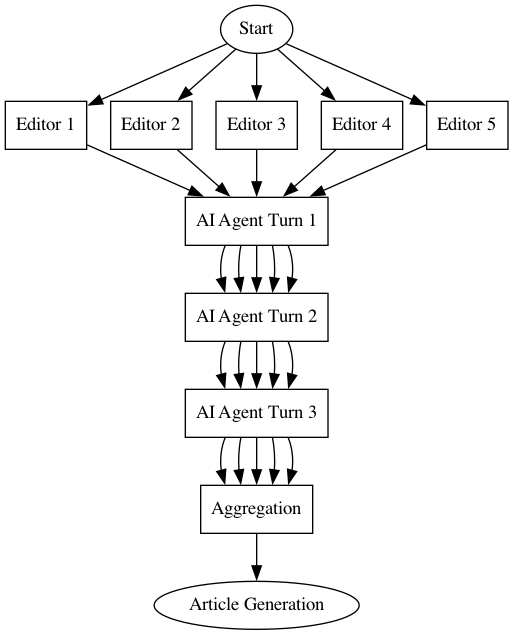

In [ ]:
from graphviz import Digraph
from IPython.display import Image, display

def create_tree_diagram_with_conversations():
    dot = Digraph(comment='Editor and AI Article Generation with Conversations')

    # Define nodes
    dot.node('start', 'Start', shape='ellipse')
    editors = [f'Editor {i+1}' for i in range(5)]
    ai_turns = [[f'AI Agent Turn {j+1}' for j in range(3)] for _ in range(5)]
    dot.node('aggregation', 'Aggregation', shape='box')
    dot.node('article_gen', 'Article Generation', shape='ellipse')

    # Define editor nodes
    for i, editor in enumerate(editors):
        dot.node(editor, editor, shape='box')
        # Define AI turns for each editor
        for j in range(3):
            dot.node(ai_turns[i][j], f'AI Agent Turn {j+1}', shape='box')

    # Define edges from Start to each Editor
    for i, editor in enumerate(editors):
        dot.edge('start', editor)
        # Define conversation turns between Editor and AI Agent
        dot.edge(editor, ai_turns[i][0])
        for j in range(2):
            dot.edge(ai_turns[i][j], ai_turns[i][j+1])
        dot.edge(ai_turns[i][2], 'aggregation')

    # Define final edges
    dot.edge('aggregation', 'article_gen')

    # Save and render the diagram
    file_path = dot.render('flow_diagram', format='png', cleanup=True)
    return file_path

file_path = create_tree_diagram_with_conversations()
display(Image(file_path))


In [ ]:
import re

def extract_searching_queries(text):
    pattern = re.compile(r'\[Searching query\]: .+')
    return pattern.findall(text)

In [ ]:
extract_searching_queries(text)

['[Searching query]: 中央企业AI领域市场定位',
 '[Searching query]: 中央企业人工智能竞争策略',
 '[Searching query]: 中国大型国企在AI行业的布局',
 '[Searching query]: 国有企业的AI技术应用案例',
 '[Searching query]: 中央企业与阿里巴巴人工智能合作案例',
 '[Searching query]: 国有企业与私营企业AI合作模式',
 '[Searching query]: 中央企业人工智能创新实践',
 '[Searching query]: 阿里巴巴集团在企业转型中的AI应用',
 '[Searching query]: 中央企业人工智能技术研发现状',
 '[Searching query]: 中央企业人工智能应用案例',
 '[Searching query]: 国家对中央企业人工智能发展的政策支持',
 '[Searching query]: 人工智能在中央企业中的战略地位',
 '[Searching query]: 最近五年中央企业人工智能领域总投资额',
 '[Searching query]: 中央企业人工智能项目的主要成就和案例',
 '[Searching query]: 中央企业在人工智能领域的研发重点',
 '[Searching query]: 中央企业与人工智能相关的关键合作',
 '[Searching query]: 中央企业人工智能技术应用的影响和评价',
 '[Searching query]: 中国移动在5G和人工智能融合中的作用',
 '[Searching query]: 中国移动5G AI技术创新案例',
 '[Searching query]: 中央企业在5G与AI融合中的角色',
 '[Searching query]: 5G与AI融合如何推动通信技术进步',
 '[Searching query]: 智能电网如何使用人工智能提高效率',
 '[Searching query]: 人工智能在智能电网可靠性中的作用',
 '[Searching query]: 智能电网项目中的人工智能应用案例',
 '[Searching query]: 中央企业人工智能应用 经济效益案例',
 '[Searching